In [5]:
%matplotlib inline
from __future__ import division
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import AppAuthHandler
from tweepy import Stream
from collections import defaultdict
import time
import tweepy
import matplotlib as plt
import time
import csv
import os
import glob
import pandas as pd
import datetime
import json
import seaborn as sns
import numpy as np

access_token = "XXX-XXX"
access_token_secret = "XXX"
consumer_key = "XXX"
consumer_secret = "XXX"

#authorize twitter, initialize tweepy
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

def get_all_tweets(user):
    #Twitter only allows access to a users most recent 3240 tweets with this method

    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = user,count=200)

    #save most recent tweets
    alltweets.extend(new_tweets)
    
    if len(new_tweets) > 0:
        #save the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        #keep grabbing tweets until there are no tweets left to grab
        while len(new_tweets) > 0:
            #print "getting tweets before %s" % (oldest)

            #all subsiquent requests use the max_id param to prevent duplicates
            new_tweets = api.user_timeline(screen_name = user,count=200,max_id=oldest)

            #save most recent tweets
            alltweets.extend(new_tweets)

            #update the id of the oldest tweet less one
            oldest = alltweets[-1].id - 1

            #print "...%s tweets downloaded so far" % (len(alltweets))

        return alltweets


In [6]:
ryan_tweets = get_all_tweets('SpendingWell')

In [9]:
with open('../data/ryandat.json', 'w') as f:
    json.dump([tweet._json for tweet in ryan_tweets], f)

In [185]:
df = pd.read_csv('../data/Twitter_Personality_pilot.csv')
df['name'] = df.Twitter_name.apply(lambda x: re.sub(r'^@', '', str(x).encode('utf8')).lower())
df['name'] = df.name.apply(lambda x: re.sub(r'^https://twitter.com/', '', str(x).encode('utf8')).lower())
df.name.replace('nan', '', inplace=True)

In [139]:

alltweets = []
for i in df.name:
    print "Tweets from user %s" % i
    try:
        tweets = get_all_tweets(i)
        print "***** user %s has %s tweets" % (i, len(tweets))
        alltweets.extend(tweets)
    except Exception as e:
        print e

Tweets from user greiss
Not authorized.
Tweets from user baebae__sanders
***** user baebae__sanders has 3205 tweets
Tweets from user fullofchange
***** user fullofchange has 1 tweets
Tweets from user wydmarq
***** user wydmarq has 3125 tweets
Tweets from user antd86
***** user antd86 has 6 tweets
Tweets from user steflynn
***** user steflynn has 2 tweets
Tweets from user gikwang
Not authorized.
Tweets from user jlschleider
***** user jlschleider has 71 tweets
Tweets from user therealmontanna
***** user therealmontanna has 542 tweets
Tweets from user dbt45
***** user dbt45 has 12 tweets
Tweets from user chasmodai
***** user chasmodai has 8 tweets
Tweets from user maido64307455
***** user maido64307455 has 297 tweets
Tweets from user mdbloomer
Not authorized.
Tweets from user chiefin785
***** user chiefin785 has 546 tweets
Tweets from user lskdjhdlkfghdlkfhgdlkfjhgdlkjfghdklfjgh
[{u'message': u'Sorry, that page does not exist.', u'code': 34}]
Tweets from user bridgesublime
Not authorized

In [140]:
with open('../data/twitterdat.json', 'w') as f:
    json.dump([tweet._json for tweet in alltweets], f)

In [3]:
with open('../data/twitterdat.json') as f:
    twitter_data = json.load(f)

In [4]:
twitter_data[0]

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Wed Jun 14 22:15:54 +0000 2017',
 u'entities': {u'hashtags': [],
  u'symbols': [],
  u'urls': [],
  u'user_mentions': []},
 u'favorite_count': 0,
 u'favorited': False,
 u'geo': None,
 u'id': 875114600764715009,
 u'id_str': u'875114600764715009',
 u'in_reply_to_screen_name': None,
 u'in_reply_to_status_id': None,
 u'in_reply_to_status_id_str': None,
 u'in_reply_to_user_id': None,
 u'in_reply_to_user_id_str': None,
 u'is_quote_status': False,
 u'lang': u'en',
 u'place': None,
 u'retweet_count': 0,
 u'retweeted': False,
 u'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 u'text': u'Working hard \U0001f613',
 u'truncated': False,
 u'user': {u'contributors_enabled': False,
  u'created_at': u'Thu Nov 25 05:48:12 +0000 2010',
  u'default_profile': False,
  u'default_profile_image': False,
  u'description': u'|IG- Baebae__Sanders| |#1 Priority is Amiyah | Taken  |',
  u'entities': {

In [172]:
names=[]
retweeted=[]
text=[]
lang=[]
created=[]
for i in twitter_data:
    names.append(i['user']['screen_name'])
    if 'retweeted_status' in i.keys():
        retweeted.append(True)
    else:
        retweeted.append(False)
    text.append(i['text'])
    lang.append(i['lang'])
    created.append(i['created_at'])

In [174]:
df_twitter = pd.DataFrame({'name':names,
                           'retweeted':retweeted,
                           'text':text,
                           'lang':lang,
                           'created':created})
df_twitter.head()
df_twitter['name'] = df_twitter.name.apply(lambda x: x.lower())

In [189]:
tweet_counts = df_twitter.groupby('name').agg({'text' : lambda x: x.count()}).reset_index()
tweet_counts_rt = df_twitter[df_twitter.retweeted==False].groupby('name').agg({'text' : lambda x: x.count()}).reset_index()

In [190]:
tweet_counts.rename(columns={'text':'total_tweets'}, inplace=True)
tweet_counts_rt.rename(columns={'text':'original_tweets'}, inplace=True)

In [191]:
df = df.merge(tweet_counts, how='left')
df = df.merge(tweet_counts_rt, how='left')

In [192]:
df

,StartDate,EndDate,Study_Type,workerId,Twitter_name,SWLS,Q3_1,Q3_2,Q3_3,Q3_4,...,Q28_7,Q28_8,Q28_9,Q28_10,Q29,Q31,Q32,name,total_tweets,original_tweets
0,2017-06-12 08:43:04,2017-06-12 08:44:47,0,A3JN8RHEW2TH3J,@Greiss,3.2,4.0,4.0,4.0,3.0,...,NaN,NaN,NaN,NaN,4.0,United States,1.0,greiss,NaN,NaN
1,2017-06-12 08:43:44,2017-06-12 08:46:36,0,A18ILYDB04VEE9,Baebae__sanders,7.0,5.0,5.0,5.0,1.0,...,NaN,NaN,NaN,NaN,3.0,USA,1.0,baebae__sanders,3205.0,2943.0
2,2017-06-12 08:44:22,2017-06-12 08:50:04,0,A3QUGJF2AN8TF2,@fullofchange,5.6,4.0,4.0,4.0,3.0,...,NaN,NaN,NaN,NaN,4.0,USA,1.0,fullofchange,1.0,1.0
3,2017-06-12 08:49:31,2017-06-12 08:51:07,0,A27ZE20JZ3VDUP,wydmarq,5.0,3.0,4.0,3.0,4.0,...,NaN,NaN,NaN,NaN,4.0,United states,1.0,wydmarq,3125.0,2460.0
4,2017-06-12 08:50:30,2017-06-12 08:52:08,0,A2JZP4AZI1RTG4,antd86,5.4,5.0,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,4.0,USA,1.0,antd86,6.0,4.0
5,2017-06-12 08:46:17,2017-06-12 08:55:03,0,A1OX59GGMHY1F3,steflynn,6.0,4.0,4.0,4.0,2.0,...,NaN,NaN,NaN,NaN,6.0,USA,1.0,steflynn,2.0,2.0
6,2017-06-12 08:56:27,2017-06-12 09:05:16,0,A2V2CV4BY2TX7D,gikwang,6.0,4.0,4.0,4.0,1.0,...,NaN,NaN,NaN,NaN,6.0,South Korea,2.0,gikwang,NaN,NaN
7,2017-06-12 09:03:29,2017-06-12 09:06:59,0,A19JD4H6DOYVMP,jlschleider,5.0,3.0,3.0,5.0,1.0,...,NaN,NaN,NaN,NaN,6.0,USA,1.0,jlschleider,71.0,64.0
8,2017-06-12 09:12:36,2017-06-12 09:19:45,0,A28NL6E1D2HLD2,TheRealMontanna,3.0,5.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,2.0,United States of America,1.0,therealmontanna,542.0,541.0
9,2017-06-12 10:11:10,2017-06-12 10:13:41,0,A1PH1I9F2AA3TZ,Dbt45,7.0,1.0,1.0,4.0,1.0,...,NaN,NaN,NaN,NaN,8.0,USA,1.0,dbt45,12.0,12.0


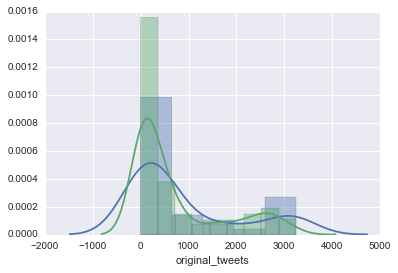

In [193]:
sns.distplot(df.total_tweets[~pd.isnull(df.total_tweets)])
sns.distplot(df.original_tweets[~pd.isnull(df.original_tweets)])

In [194]:
df.to_csv('../data/twitterdat.csv', index=False)

In [ ]:
def get_all_tweets(idnum):
    #Twitter only allows access to a users most recent 3240 tweets with this method

    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(id = idnum,count=200)

    #save most recent tweets
    alltweets.extend(new_tweets)
    
    if len(new_tweets) > 0:
        #save the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        #keep grabbing tweets until there are no tweets left to grab
        while len(new_tweets) > 0:
            #print "getting tweets before %s" % (oldest)

            #all subsiquent requests use the max_id param to prevent duplicates
            new_tweets = api.user_timeline(id = idnum,count=200,max_id=oldest)

            #save most recent tweets
            alltweets.extend(new_tweets)

            #update the id of the oldest tweet less one
            oldest = alltweets[-1].id - 1

            #print "...%s tweets downloaded so far" % (len(alltweets))

        #transform the tweepy tweets into a 2D array that will populate the csv 
        outtweets = [[tweet._json['user']['screen_name'], tweet.id_str, tweet.created_at, 
                      tweet.text.encode("utf-8"), tweet.geo] for tweet in alltweets]
        return outtweets

def write_data(tweets):
    outdat = []
    for user in tweets:
        if user:
            for tweet in user:
                outdat.append([tweet[0], tweet[1], tweet[2], tweet[3], tweet[4]])
    current_time = time.strftime("%m.%d.%y.%H:%M:%S", time.localtime())
    outname = 'tweets_%s.csv' %current_time
    with open(outname, 'wb') as f:
        writer=csv.writer(f)
        writer.writerow(['screen_name', 'tweet_id', 'created_at', 'text', 'geo'])
        writer.writerows(outdat)

def get_data(path, reduced=True):
    files = glob.glob(path+'*.csv')
    df_list = []
    for f in files:
        d = pd.read_csv(f)
        d['created_at'] = pd.to_datetime(d['created_at'])
        if reduced:
            d = reduced_data(d)
        df_list.append(d)
    data = pd.concat(df_list, ignore_index=True)
    return (data)

def reduced_data(df):
    dat = df[df['created_at']<datetime.datetime(2014,8,23,12)]
    dat = dat[dat['created_at']>datetime.datetime(2014,7,26,12)]
    return(dat)

def get_followers(sources):
    ids = []
    for user in sources:
        for page in tweepy.Cursor(api.followers_ids, screen_name=user).pages():
            ids.extend(page)
    #keep nonduplicated ids      
    ids = set(ids)
    return(ids)

def check_collected_dat(ids, collected_ids):
    user_ids = []
    for user in collected_ids:
        try:
            u = api.get_user(screen_name=user)
            user_ids.append(u.id)
        except Exception as e:
            pass
    rem_ids = [x for x in ids if x not in user_ids]
    return(rem_ids)

def write_user_info(user_dict):
    current_time = time.strftime("%m.%d.%y.%H:%M:%S", time.localtime())
    outname = 'users_%s.json' %current_time
    with open(outname, 'wb') as f:
        json.dump(user_dict, f)

sourcenodes = ['AsAmNews'] 
try:
    d = get_data(os.getcwd()+'/', reduced=False)
    ids = get_followers(sourcenodes)
    ids = check_collected_dat(ids, set(d.screen_name))
except:
    ids = get_followers(sourcenodes)

tweettimelines = []
user_dict = {}
for i, person in enumerate(ids):
    print "getting tweets from %s. This is user %s of %s. %s until filewrite" % (person, i, len(ids), 500-len(tweettimelines))
    try:
        u = api.get_user(id=person)
        user_dict[u.screen_name] = u._json
        tweettimelines.append(get_all_tweets(person))
    except Exception as e:
        print e
        pass
    if len(tweettimelines)==500:
        write_data(tweettimelines)
        write_user_info(user_dict)
        user_dict = {}
        tweettimelines=[]
write_data(tweettimelines)